In [1]:
import sys
sys.version

'3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]'

Make sure your Python version is compatible with Python MIP package!

***
# MOSES 2025 Conference Analysis Notebook
by Fabian Nolz
- Clustered Operational Data -> multi scenario
- Multiple fuels
- Multiple nonlinear engines and fuel cells (multi conversion technology)

***
## Setup
- graph_v2() is the function to plot the dynamic graph visually
- optigraph_scenarios() actually creates the mathematical formulation and returns the optimal node & edge data

In [2]:
import numpy as np
import math
from IPython.display import IFrame
from mip import *
import matplotlib.pyplot as plt
import pandas

In [3]:
def siground(x, sig=4, cap=1e-8):
    if x == 0:
        return 0.0
    order = math.floor(math.log10(abs(x)))
    rounded = round(x, sig - order - 1)
    return 0.0 if abs(rounded) < cap else rounded

In [4]:
def getvalue(cell, t=0):
    if isinstance(cell, (list, np.ndarray)):  # return the value in the cells array, case of multiple scenarios
        return cell[t]
    elif isinstance(cell, (int, float)):  # nan, int and float value in table
        return cell

In [5]:
def graph_v2(nodes, edges, t=0, width=800, height=500, verbose=False):
    """features:
        - all values are in lists, visualise a specific index"""
    begin = []
    with open("begin-dash-label.txt", "r") as text_file:
    #with open("begin.txt", "r") as text_file:
        begin = text_file.readlines()
    mid = ['                ],"nodes":[\n']
    end = []
    with open("end.txt", "r") as text_file:
        end = text_file.readlines()
    
    def getit(name):
        # if verbose: print(name)
        # print(name)
        return nodes.index[nodes['name'] == name][0]
    
    def stroke(edges, i):
        value = getvalue(edges.loc[i, 'value'], t)
        unit = edges.loc[i, 'unit']
        if pandas.isna(value) or value==0:
            return "", 1, 0
        else:
            maxi = edges.loc[edges["unit"]==unit, "value"].apply(lambda x: np.max(x) if isinstance(x, (list, np.ndarray)) else 0).max()
            return "{:.4g} {}".format(value, unit), value/maxi*3.4 + 0.5, 1
    
    l = ['                    {{"marker_color":"#808080","marker_start":"","marker_end":"arrow","weight":30.0,"color":"#808080","label":"{}","label_color":"#808080","label_fontsize":8,"edge_width":{},"edge_distance":100.0,"edge_style":{},"edge_weight":1,"source":{},"target":{},"source_label":"{}","target_label":"{}"}},\n'.format(
        *stroke(edges, i), getit(edges.iloc[i]['source']), getit(edges.iloc[i]['target']), edges.iloc[i]['source'], edges.iloc[i]['target'] ) for i in range(len(edges))]
    edge_string = '!'.join(l)
    edge_list = edge_string.split('!')
    
    def nodeformat(t):
        if t == "machinery":
            return "#555"
        else:
            return "#fff"
    
    l = ['                    {{"name":"{}","group":"{}","node_name":"100","node_marker":"circle","node_tooltip":"100","node_color":"#000000","node_opacity":"1.0","node_size":"8.0","node_size_edge":"1","node_color_edge":"{}","node_fontcolor":"#000000","node_fontsize":"12"}},\n'.format(
        nodes.iloc[i]['name'], nodes.iloc[i]['cluster'], nodeformat(nodes.iloc[i]['type']) ) for i in range(len(nodes))]
    node_string = '!'.join(l)
    node_list = node_string.split('!')

    with open("elasticgraph.html", "w") as text_file:
        text_file.writelines(begin+edge_list+mid+node_list+end)

    return IFrame(src="elasticgraph.html", width=width, height=height)

In [6]:
def get_edgename(time, sourcename, targetname):
    return "_".join("x {} {} to {}".format(time, sourcename, targetname).split())

def get_connected(nodename, nodes, edges):
    inputs  = [edges['source'][edgeindex] for edgeindex in edges.index[edges['target'] == nodename]]
    outputs = [edges['target'][edgeindex] for edgeindex in edges.index[edges['source'] == nodename]]
    return inputs, outputs

def get_connected_index(nodename, nodes, edges):
    inputs  = [edgeindex for edgeindex in edges.index[edges['target'] == nodename]]
    outputs = [edgeindex for edgeindex in edges.index[edges['source'] == nodename]]
    return inputs, outputs

def get_x_from_name(name, df):
    return df["variable"][df.index[df["name"] == name][0]]

def get_index_from_name(name, df):
    return df.index[df["name"] == name][0]

def write_list(df, index, column, lst):
    df.loc[[index], column] = pandas.Series([lst], index=df.index[[index]])

def optigraph_scenarios(nodes, edges, n_scenarios=1):
    m = Model()
    m.verbose = 0

    x_m_max = []
    for i in range(len(nodes)):
        nodename = nodes.loc[i, "name"]
        machinerycost = nodes.loc[i, "cost"]
        if nodes["type"][get_index_from_name(nodename, nodes)] == "machinery":
            machineryvar = m.add_var(name='max_m_{}'.format(nodename), obj=machinerycost)
            x_m_max.append(machineryvar)

    for t in range(n_scenarios):

        x = []
        for i in range(len(edges.index)):
            edgename = get_edgename(t, edges['source'][i], edges['target'][i])
            edgecost = 0 if pandas.isna(edges.loc[i, "cost"]) else getvalue(edges.loc[i, "cost"], t)
            lb = 0 if pandas.isna(edges.loc[i, "lb"]) else getvalue(edges.loc[i, "lb"], t)
            ub = float("inf") if pandas.isna(edges.loc[i, "ub"]) else getvalue(edges.loc[i, "ub"], t)
            x.append(m.add_var(name=edgename, obj=edgecost, lb=lb, ub=ub))

        variabledf = pandas.DataFrame(np.array([x, [x[i].name for i in range(len(x))]]).transpose(), columns=["variable", "name"])

        def get_column_from_name(name, df, column):
            return df[column][df.index[df["name"] == name][0]]

        # every machinery node splits into its significant flow variable with its in- and out-ratios
        x_m = []
        for n in range(len(nodes)):
            nodename = nodes["name"][n]
            if nodes["type"][get_index_from_name(nodename, nodes)] == "machinery":
                machineryvar = m.add_var(name='m_{}_{}'.format(t, nodename))
                x_m.append(machineryvar)

                # if isinstance(nodes.loc[n, "SOS2"], (list, np.ndarray)):  # nonlinear machinery
                discontinuous = False
                sos2 = nodes.loc[n, "SOS2"]
                nonlinear = False
                if isinstance(sos2, list):  # nonlinear machinery
                    # print("##############", nodename)
                    nonlinear = True
                    D = len(sos2)
                    if nodes.loc[n, "SOS2"][0] > 0:  # if no zero load point defined a machinery may still be shut down
                        discontinuous = True
                        sos2 = [0,sos2[0]/2]+sos2  # add a shut off state and ordered uninterpolateable intermediate state before load states
                        # write_list(nodes, n, "SOS2", [0,sos2[0]/2]+sos2)
                        # nodes.loc[[n], "SOS2"] = pandas.Series([lst], index=df.index[[index]])
                        # print('---',sos2)
                        D += 2
                        w = [m.add_var() for d in range(D)]  # interpolation variables
                        m += w[1] == 0  # constrain intermediate point to be unusable and interpolation discontinuous (not a step but a gap)
                    else:
                        w = [m.add_var() for d in range(D)]  # interpolation variables
                    m += xsum(w) == x_m_max[len(x_m)-1]  # convexification with upper limit
                    m += machineryvar == xsum(sos2[k] * w[k] for k in range(D))  # define the load variable
                    m.add_sos([(w[k], sos2[k]) for k in range(D)], 2)
                    # print([(w[k].name, sos2[k]) for k in range(D)])
                else:  # max() formulation of linear machinery
                    m += machineryvar <= x_m_max[len(x_m)-1], "max_{}".format(machineryvar.name)

                inp, out = get_connected(nodename, nodes, edges)
                inpi, outi = get_connected_index(nodename, nodes, edges)

                for i in range(len(inp)):
                    edgename = get_edgename(t, inp[i], nodename)
                    edgeratio = edges['inratio'][inpi[i]]

                    if isinstance(edgeratio, (list, np.ndarray)):
                    # if isinstance(edgeratio, list):
                        if nonlinear:  # nonlinear machinery
                            if discontinuous:
                                edgeratio = [0,0]+edgeratio
                                # edges['inratio'][inpi[i]] = edgeratio
                            m += x[get_index_from_name(edgename, variabledf)] == xsum(edgeratio[k] * w[k] * sos2[k] for k in range(D)), "nonlinear_{}_{}".format(t, "_".join(edgename.split()))
                        else:  # multi scenario machinery
                            m += x[get_index_from_name(edgename, variabledf)] == edgeratio[t] * machineryvar, "inratio_{}_{}".format(t, "_".join(edgename.split()))
                    else:  # simple single ratio machinery
                        m += x[get_index_from_name(edgename, variabledf)] == edgeratio * machineryvar, "inratio_{}".format(t, "_".join(edgename.split()))

                for i in range(len(out)):
                    edgename = get_edgename(t, nodename, out[i])
                    edgeratio = edges['outratio'][outi[i]]

                    if isinstance(edgeratio, (list, np.ndarray)):
                    # if isinstance(edgeratio, list):
                        if nonlinear:  # nonlinear machinery
                            if discontinuous:
                                edgeratio = [0,0]+edgeratio
                                # edges['outratio'][outi[i]] = edgeratio
                            m += x[get_index_from_name(edgename, variabledf)] == xsum(edgeratio[k] * w[k] * sos2[k] for k in range(D)), "nonlinear_{}_{}".format(t, "_".join(edgename.split()))
                        else:  # multi scenario machinery
                            m += x[get_index_from_name(edgename, variabledf)] == edgeratio[t] * machineryvar, "outratio_{}_{}".format(t, "_".join(edgename.split()))
                    else:
                        m += x[get_index_from_name(edgename, variabledf)] == edgeratio * machineryvar, "outratio_{}".format(t, "_".join(edgename.split()))

        # every commodity node preserves its flow quantity
        for n in range(len(nodes)):
            nodename = nodes["name"][n]
            inp, out = get_connected(nodename, nodes, edges)
            if nodes["type"][get_index_from_name(nodename, nodes)] == "commodity":
                m += xsum(x[get_index_from_name(get_edgename(t, node, nodename), variabledf)] for node in inp) - xsum(x[get_index_from_name(get_edgename(t, nodename, node), variabledf)] for node in out) == 0, "constrain_{}_{}".format(t, "_".join(nodename.split()))

        # every source/demand node has prescribed in/out-flow quantity
        for n in range(len(nodes)):
            nodename = nodes["name"][n]
            inp, out = get_connected(nodename, nodes, edges)
            if nodes["type"][get_index_from_name(nodename, nodes)] == "source":
                m += xsum(x[get_index_from_name(get_edgename(t, nodename, node), variabledf)] for node in out) == getvalue(nodes["sourcevalue"][n], t), "source_{}_{}".format(t, "_".join(nodename.split()))
            if nodes["type"][get_index_from_name(nodename, nodes)] == "demand":
                m += xsum(x[get_index_from_name(get_edgename(t, node, nodename), variabledf)] for node in inp) == getvalue(nodes["sinkvalue"][n], t), "demand_{}_{}".format(t, "_".join(nodename.split()))

    m.write('model.lp')
    status = m.optimize()
    print(status, m.objective_value)
    
    varlist = lambda t: list(filter(None, [(i, v.name) if v.name.startswith("x_{}".format(t)) else None for i, v in enumerate(m.vars)]))
    post_edges = edges.copy()
    for i in post_edges.index:
        # post_edges.loc[i, 'value'] = [0,0]
        scenariovalues = [siground(m.vars[varlist(t)[i][0]].x) for t in range(n_scenarios)]
        post_edges.loc[[i], 'value'] = pandas.Series([scenariovalues], index=post_edges.index[[i]])  # https://stackoverflow.com/questions/48000225/must-have-equal-len-keys-and-value-when-setting-with-an-iterable
    # post_edges.fillna('')
    
    mlist = list(filter(None, [(i, v.name) if v.name.startswith("max_m") else None for i, v in enumerate(m.vars)]))
    # mlist
    post_nodes = nodes.copy()
    for i in range(len(mlist)):
        machineryvalue = siground(m.vars[mlist[i][0]].x)
        post_nodes.loc[post_nodes['name']==mlist[i][1].replace('max_m_',''), 'installed'] = machineryvalue
    # post_nodes.fillna('')
    
    return m, post_nodes, post_edges

***
## Model Setup
- first cell: all the main coefficients used from fuel prices to engine efficiency
- second cell: the actual ship model definition

In [8]:
GHG_CH4 = 25  # https://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=CELEX:32018L2001
GHG_N2O = 298  # CO2eq 100 year GHG values

cost_HFO = 0.45  # €/kg
cost_VLSFO = 0.6  # €/kg
LHV_HFO = 40.5  # MJ/kg
WtT_HFO = 13.2e-3  # kgCO2eq/MJ well to tank FuelEU
CO2_HFO = 3.114  # gCO2/gFuel
CH4_HFO = 0.00005  # gCH4/gFuel
N2O_HFO = 0.00018  # gN2O/gFuel
TtW_HFO = (CO2_HFO+CH4_HFO*GHG_CH4+N2O_HFO*GHG_N2O)/LHV_HFO  # kgCO2eq/MJ tank to wake FuelEU
print(f"HFO {cost_HFO/LHV_HFO*3.6:.4f} €/kWh, WtW {(WtT_HFO+TtW_HFO)*3.6:.4f} kgCO2eq/kWh")
print(f"VLSFO {cost_VLSFO/LHV_HFO*3.6:.4f} €/kWh, WtW {(WtT_HFO+TtW_HFO)*3.6:.4f} kgCO2eq/kWh")

cost_MGO = 0.73  # €/kg
# cost_LSF = 0.85  # €/kg
LHV_MGO = 42.7  # MJ/kg
WtT_MGO = 14.4e-3  # kgCO2eq/MJ well to tank FuelEU
# WtT_LSF = 13.2e-3  # kgCO2eq/MJ my estimation ################# its a HFO type, not MDO/MGO
CO2_MGO = 3.206  # gCO2/gFuel
CH4_MGO = 0.00005  # gCH4/gFuel
N2O_MGO = 0.00018  # gN2O/gFuel
TtW_MGO = (CO2_MGO+CH4_MGO*GHG_CH4+N2O_MGO*GHG_N2O)/LHV_MGO  # kgCO2eq/MJ well to tank FuelEU
print(f"MGO {cost_MGO/LHV_MGO*3.6:.4f} €/kWh, WtW {(WtT_MGO+TtW_MGO)*3.6:.4f} kgCO2eq/kWh")

cost_LNG = 0.78  # €/kg
cost_bioLNG = 1.0  # €/kg
LHV_LNG = 49.1  # MJ/kg # can be as low as 45% due to mixing with butane/propane?
WtT_LNG = 18.5e-3  # kgCO2eq/MJ well to tank FuelEU
# WtT_bioLNG = -60e-3  # kgCO2eq/MJ well to tank FuelEU
WtT_bioLNG = 0  # kgCO2eq/MJ well to tank FuelEU ########################################### cannot process negative yet
# WtT_bioLNG = 60e-3  # kgCO2eq/MJ well to tank FuelEU ########################################### cannot process negative yet
CO2_LNG = 2.75  # gCO2/gFuel
CH4_LNG = 0.031  # gCH4/gFuel
N2O_LNG = 0.00011  # gN2O/gFuel
TtW_LNG = (CO2_LNG+CH4_LNG*GHG_CH4+N2O_LNG*GHG_N2O)/LHV_LNG  # kgCO2eq/MJ well to tank FuelEU
TtW_bioLNG = ((CO2_LNG+CH4_LNG*GHG_CH4+N2O_LNG*GHG_N2O-60e-3)/LHV_LNG)  # kgCO2eq/MJ well to tank FuelEU
print(f"LNG {cost_LNG/LHV_LNG*3.6:.4f} €/kWh, WtW {(WtT_LNG+TtW_LNG)*3.6:.4f} kgCO2eq/kWh")
print(f"bioLNG {cost_bioLNG/LHV_LNG*3.6:.4f} €/kWh, WtW {(WtT_bioLNG+TtW_bioLNG)*3.6:.4f} kgCO2eq/kWh")

cost_LH2 = 3.22  # €/kg
cost_reLH2 = 5.04  # €/kg
LHV_LH2 = 120  # MJ/kg
WtT_LH2 = 132e-3  # kgCO2eq/MJ well to tank FuelEU
WtT_reLH2 = 20e-3  # kgCO2eq/MJ well to tank FuelEU
TtW_LH2 = 0  # kgCO2eq/MJ tank to wake FuelEU
print(f"LH2 {cost_LH2/LHV_LH2*3.6:.4f} €/kWh, WtW {(WtT_LH2+TtW_LH2)*3.6:.4f} kgCO2eq/kWh")
print(f"reLH2 {cost_reLH2/LHV_LH2*3.6:.4f} €/kWh, WtW {(WtT_reLH2+TtW_LH2)*3.6:.4f} kgCO2eq/kWh")

cost_NH3 = 0.39  # €/kg
cost_reNH3 = 0.93  # €/kg
LHV_NH3 = 18.6  # MJ/kg
WtT_NH3 = 121e-3  # kgCO2eq/MJ well to tank FuelEU
WtT_reNH3 = 26.4e-3  # kgCO2eq/MJ own estimate from reH2 plus H-B's reEL 0,095
CO2_NH3 = 0  # gCO2/gFuel
CH4_NH3 = 0  # gCH4/gFuel
N2O_NH3 = 0  # gN2O/gFuel
TtW_NH3 = (CO2_NH3+CH4_NH3*GHG_CH4+N2O_NH3*GHG_N2O)/LHV_NH3  # kgCO2eq/MJ well to tank FuelEU
print(f"NH3 {cost_NH3/LHV_NH3*3.6:.4f} €/kWh, WtW {(WtT_NH3+TtW_NH3)*3.6:.4f} kgCO2eq/kWh")
print(f"reNH3 {cost_reNH3/LHV_NH3*3.6:.4f} €/kWh, WtW {(WtT_reNH3+TtW_NH3)*3.6:.4f} kgCO2eq/kWh")

cost_MOH = 0.36  # €/kg
LHV_MOH = 19.9  # MJ/kg
WtT_MOH = 31.3e-3  # kgCO2eq/MJ well to tank FuelEU
CO2_MOH = 1.375  # gCO2/gFuel
CH4_MOH = 0  # gCH4/gFuel
N2O_MOH = 0  # gN2O/gFuel
TtW_MOH = (CO2_MOH+CH4_MOH*GHG_CH4+N2O_MOH*GHG_N2O)/LHV_MOH  # kgCO2eq/MJ well to tank FuelEU
print(f"MOH {cost_MOH/LHV_MOH*3.6:.4f} €/kWh, WtW {(WtT_MOH+TtW_MOH)*3.6:.4f} kgCO2eq/kWh")

cost_mixEL = 0.08  # €/kWh
WtT_mixEL = 140e-3  # kgCO2eq/MJ well to tank FuelEU
print(f"mixEL {cost_mixEL:.4f} €/kWh, WtW {WtT_mixEL*3.6:.4f} kgCO2eq/kWh")
cost_reEL = 0.10  # €/kWh
WtT_reEL = 5e-3  # kgCO2eq/MJ well to tank FuelEU
print(f"reEL {cost_reEL:.4f} €/kWh, WtW {WtT_reEL*3.6:.4f} kgCO2eq/kWh")

cost_luboil = 7  # €/kg
carbontax = 66e-3  # €/gCO2eq

r = 0.03  # interest rate
t = 20  # lifeyears
CRF = r*(1+r)**t/((1+r)**t-1)  # capital recovery factor

# SOS_ICE = [0.2, 0.362, 0.5202, 0.6806, 0.8399, 1.0]
# eta_ICE = np.array([0.4066, 0.4315, 0.4505, 0.4625, 0.466, 0.4606])
SOS_ICE = [0.2, 0.4809, 0.7379, 1.0]
eta_ICE = np.array([0.4133, 0.4541, 0.4728, 0.4681])
capex_ICE = 343*CRF # €/kW
capex_DICE = (525-343)*CRF
capex_SCRUBBER = 107*CRF
capex_SCR = 39.5*CRF
capex_EGR = 80*CRF

# SOS_PEMFC = [0.15, 0.85, 0.97, 1.0]
# eta_PEMFC = np.array([0.7143, 0.5603, 0.5149, 0.4804])
SOS_PEMFC = [0.17, 0.33, 1.0]
eta_PEMFC = np.array([0.6, 0.6, 0.47]) # Yuksel25
capex_PEMFC = 1450*CRF

SOS_SOFC = [0.2, 1.0]
eta_SOFC = np.array([0.65, 0.6])
capex_SOFC = 2620*CRF

capex_BOIL = 111*CRF
capex_EGB = 111*CRF

capex_MOT = 138*CRF
capex_DCDC = 168*CRF
capex_DCAC = 290*CRF
# capex_ACAC = 111*CRF
capex_GRBX = 72*CRF
capex_SHAFT = 80*CRF
capex_PROP = 30*CRF
capex_RO = 22000*CRF

HFO 0.0400 €/kWh, WtW 0.3292 kgCO2eq/kWh
VLSFO 0.0533 €/kWh, WtW 0.3292 kgCO2eq/kWh
MGO 0.0615 €/kWh, WtW 0.3268 kgCO2eq/kWh
LNG 0.0572 €/kWh, WtW 0.3275 kgCO2eq/kWh
bioLNG 0.0733 €/kWh, WtW 0.2565 kgCO2eq/kWh
LH2 0.0966 €/kWh, WtW 0.4752 kgCO2eq/kWh
reLH2 0.1512 €/kWh, WtW 0.0720 kgCO2eq/kWh
NH3 0.0755 €/kWh, WtW 0.4356 kgCO2eq/kWh
reNH3 0.1800 €/kWh, WtW 0.0950 kgCO2eq/kWh
MOH 0.0651 €/kWh, WtW 0.3614 kgCO2eq/kWh
mixEL 0.0800 €/kWh, WtW 0.5040 kgCO2eq/kWh
reEL 0.1000 €/kWh, WtW 0.0180 kgCO2eq/kWh


In [9]:
def shipmodel(ELcases, ROTcases, WATERcases, STEAMcases, hours, portmode, carbontax):#, trajectory):
    nodes = pandas.DataFrame([
        {"name": "luboil",            "type": "boundary",   "cluster": "bunkering"},
        {"name": "luboilconv",        "type": "machinery",  "cluster": "tank",         "cost": 0},
        
        {"name": "tankheater",        "type": "machinery",  "cluster": "steamsystem",  "cost": 0},
        {"name": "tankheat",          "type": "commodity",  "cluster": "tank"},
        
        # {"name": "HFO",               "type": "boundary",   "cluster": "bunkering"},
        # {"name": "HFOconv",           "type": "machinery",  "cluster": "tank",         "cost": 0},
        {"name": "VLSFO",             "type": "boundary",   "cluster": "bunkering"},
        {"name": "VLSFOconv",         "type": "machinery",  "cluster": "tank",         "cost": 0},
        {"name": "FO_LHV",            "type": "commodity",  "cluster": "tank"},
        
        {"name": "MGO",               "type": "boundary",   "cluster": "bunkering"},
        {"name": "MGOconv",           "type": "machinery",  "cluster": "tank",         "cost": 0},
        {"name": "GO_LHV",            "type": "commodity",  "cluster": "tank"},
        
        {"name": "LNG",               "type": "boundary",   "cluster": "bunkering"},
        {"name": "LNGconv",           "type": "machinery",  "cluster": "tank",         "cost": 0},
        {"name": "bioLNG",            "type": "boundary",   "cluster": "bunkering"},
        {"name": "bioLNGconv",        "type": "machinery",  "cluster": "tank",         "cost": 0},
        {"name": "LNG_LHV",           "type": "commodity",  "cluster": "tank"},
        
        {"name": "NH3",               "type": "boundary",   "cluster": "bunkering"},
        {"name": "NH3conv",           "type": "machinery",  "cluster": "tank",         "cost": 0},
        {"name": "reNH3",             "type": "boundary",   "cluster": "bunkering"},
        {"name": "reNH3conv",         "type": "machinery",  "cluster": "tank",         "cost": 0},
        {"name": "NH3_LHV",           "type": "commodity",  "cluster": "tank"},
        
        {"name": "MOH",               "type": "boundary",   "cluster": "bunkering"},
        {"name": "MOHconv",           "type": "machinery",  "cluster": "tank",         "cost": 0},
        {"name": "MOH_LHV",           "type": "commodity",  "cluster": "tank"},
        
        {"name": "LH2",               "type": "boundary",   "cluster": "bunkering"},
        {"name": "LH2conv",           "type": "machinery",  "cluster": "tank",         "cost": 0},
        {"name": "reLH2",             "type": "boundary",   "cluster": "bunkering"},
        {"name": "reLH2conv",         "type": "machinery",  "cluster": "tank",         "cost": 0},
        {"name": "LH2_LHV",           "type": "commodity",  "cluster": "tank"},
        
        {"name": "gas_LHV",           "type": "commodity",  "cluster": "tank"},
        {"name": "oil_LHV",           "type": "commodity",  "cluster": "tank"},
        {"name": "PEMFC_LHV",         "type": "commodity",  "cluster": "tank"},
        {"name": "SOFC_LHV",          "type": "commodity",  "cluster": "tank"},
    
        {"name": "reEL",              "type": "boundary",   "cluster": "coldironing"},
        {"name": "reELconv",          "type": "machinery",  "cluster": "coldironing",  "cost": 0},
        {"name": "mixEL",             "type": "boundary",   "cluster": "coldironing"},
        {"name": "mixELconv",         "type": "machinery",  "cluster": "coldironing",  "cost": 0},
        {"name": "EL",                "type": "commodity",  "cluster": "coldironing"},
        {"name": "shoreconnection",   "type": "machinery",  "cluster": "coldironing",  "cost": 0},
        
        {"name": "WtT",               "type": "commodity",  "cluster": "emissions"},
        {"name": "TtW",               "type": "commodity",  "cluster": "emissions"},
        {"name": "WtW",               "type": "commodity",  "cluster": "emissions"},
        {"name": "environment",       "type": "boundary",   "cluster": "emissions"},
        # {"name": "environment",       "type": "demand",  "cluster": "demands",   "sinkvalue": trajectory},
        
        # {"name": "negWtW",            "type": "machinery",  "cluster": "emissions",    "cost": 0},
        # {"name": "WtWdump",           "type": "boundary",  "cluster": "emissions"},
        # {"name": "powersum",          "type": "commodity",  "cluster": "emissions"},
        # {"name": "refWtW",            "type": "machinery",  "cluster": "emissions",    "cost": 0},
        # {"name": "GHGcomm",           "type": "commodity",  "cluster": "emissions"},
        # {"name": "GHGsurplus",        "type": "boundary",   "cluster": "emissions"},
        
        # {"name": "scrubberNeed",      "type": "commodity",  "cluster": "scrubber"},
        # {"name": "scrubber",          "type": "machinery",  "cluster": "scrubber",     "cost": capex_SCRUBBER},
        
        {"name": "luboil_ICE",        "type": "commodity",  "cluster": "engineroom"},
        {"name": "fuel_DICE",         "type": "machinery",  "cluster": "engineroom",   "cost": capex_DICE},
        {"name": "main_LHV",          "type": "commodity",  "cluster": "engineroom"},
        {"name": "engine_ICE_1",        "type": "machinery",  "cluster": "engineroom",   "cost": capex_ICE, "SOS2": SOS_ICE}, #"SOS1": 1200*np.array([0,6,7,8,9,12,14,16])
        {"name": "engine_ICE_2",        "type": "machinery",  "cluster": "engineroom",   "cost": capex_ICE, "SOS2": SOS_ICE},
        {"name": "engine_ICE_3",        "type": "machinery",  "cluster": "engineroom",   "cost": capex_ICE, "SOS2": SOS_ICE},
        {"name": "engine_ICE_4",        "type": "machinery",  "cluster": "engineroom",   "cost": capex_ICE, "SOS2": SOS_ICE},
        {"name": "exhaustheat",       "type": "commodity",  "cluster": "engineroom"},
        {"name": "engine_rotation",   "type": "commodity",  "cluster": "engineroom"},
        
        {"name": "EGB",               "type": "machinery",  "cluster": "steamsystem",   "cost": capex_EGB},
        {"name": "boiler_LHV",        "type": "commodity",  "cluster": "steamsystem"},
        {"name": "boiler",            "type": "machinery",  "cluster": "steamsystem",   "cost": capex_BOIL},
        {"name": "steam",             "type": "commodity",  "cluster": "steamsystem"},
        {"name": "steamdemand",       "type": "demand",     "cluster": "steamsystem",   "sinkvalue": STEAMcases},
        {"name": "steamdumping",      "type": "boundary",   "cluster": "steamsystem"},
        
        {"name": "PEMFC_1",           "type": "machinery",  "cluster": "fuelcellroom", "cost": capex_PEMFC, "SOS2": SOS_PEMFC},
        {"name": "PEMFC_2",           "type": "machinery",  "cluster": "fuelcellroom", "cost": capex_PEMFC, "SOS2": SOS_PEMFC},
        {"name": "PEMFC_3",           "type": "machinery",  "cluster": "fuelcellroom", "cost": capex_PEMFC, "SOS2": SOS_PEMFC},
        {"name": "SOFC_1",            "type": "machinery",  "cluster": "fuelcellroom", "cost": capex_SOFC, "SOS2": SOS_SOFC},
        {"name": "SOFC_2",            "type": "machinery",  "cluster": "fuelcellroom", "cost": capex_SOFC, "SOS2": SOS_SOFC},
        {"name": "SOFC_3",            "type": "machinery",  "cluster": "fuelcellroom", "cost": capex_SOFC, "SOS2": SOS_SOFC},
        {"name": "DC_electricity",    "type": "commodity",  "cluster": "fuelcellroom"},
        {"name": "DCAC",              "type": "machinery",  "cluster": "fuelcellroom", "cost": capex_DCAC},
        {"name": "electricity",       "type": "commodity",  "cluster": "power"},
        
        {"name": "shaft",             "type": "machinery",  "cluster": "power",   "cost": capex_SHAFT},
        # {"name": "motor_PTI",         "type": "machinery",  "cluster": "power",   "cost": 113*CRF},
        {"name": "motor",             "type": "machinery",  "cluster": "power",   "cost": capex_MOT},
        {"name": "generator",         "type": "machinery",  "cluster": "power",   "cost": capex_MOT},
        {"name": "rotation",          "type": "commodity",  "cluster": "power"},
        {"name": "propulsiondemand",  "type": "demand",     "cluster": "power",   "sinkvalue": ROTcases},  # a sink (source) should connect with one edge exactly, more means double sinking?
        {"name": "electricitydemand", "type": "demand",     "cluster": "power",   "sinkvalue": ELcases},
        
        {"name": "reverseosmosis",    "type": "machinery",  "cluster": "freshwater",   "cost": capex_RO},
        {"name": "freshwater",        "type": "commodity",  "cluster": "freshwater"},
        {"name": "waterdemand",       "type": "demand",     "cluster": "freshwater",   "sinkvalue": WATERcases},
        ], columns=[
         "name", "type", "cluster", "cost", "sinkvalue", "sourcevalue", "installed", "SOS2", "SOS1",
        ])
    
    euro = "\\u20AC"
    
    edges = pandas.DataFrame([
        {"source": "luboil",      "target": "luboilconv",      "unit": "kg", "inratio": 1,  "cost": cost_luboil},
        {"source": "luboilconv",  "target": "luboil_ICE",      "unit": "kg/h", "outratio": 1/hours},
        
        {"source": "steam",       "target": "tankheater",      "unit": "kW", "inratio": 1},
        {"source": "tankheater",  "target": "tankheat",        "unit": "kWh", "outratio": hours},
        # {"source": "tankheat",    "target": "HFOconv",         "unit": "kWh", "inratio": 1.9/3600*(140-30)}, # 2kJ/kgK / 3600kJ/kWh * deltaT °C
        {"source": "tankheat",    "target": "VLSFOconv",       "unit": "kWh", "inratio": 2/3600*(120-30)}, # 2kJ/kgK / 3600kJ/kWh * deltaT °C
        {"source": "tankheat",    "target": "MGOconv",         "unit": "kWh", "inratio": 2.1/3600*(60-30)}, # 2kJ/kgK / 3600kJ/kWh * deltaT °C
    
        # {"source": "HFO",         "target": "HFOconv",         "unit": "kg", "inratio": 1,  "cost": cost_HFO},
        # {"source": "HFOconv",     "target": "FO_LHV",          "unit": "kW", "outratio": LHV_HFO/3.6/hours},
        # # {"source": "HFOconv",     "target": "powersum",        "unit": "kW", "outratio": LHV_HFO/3.6/hours},
        # {"source": "HFOconv",     "target": "WtT",             "unit": "kgCO2eq", "outratio": WtT_HFO*LHV_HFO}, # kgCO2eq/MJ * MJ/kg
        # {"source": "HFOconv",     "target": "TtW",             "unit": "kgCO2eq", "outratio": TtW_HFO*LHV_HFO},
        
        {"source": "VLSFO",       "target": "VLSFOconv",       "unit": "kg", "inratio": 1,  "cost": cost_VLSFO},
        {"source": "VLSFOconv",   "target": "FO_LHV",          "unit": "kW", "outratio": LHV_HFO/3.6/hours},
        # {"source": "VLSFOconv",   "target": "powersum",        "unit": "kW", "outratio": LHV_HFO/3.6/hours},
        {"source": "VLSFOconv",   "target": "WtT",             "unit": "kgCO2eq", "outratio": WtT_HFO*LHV_HFO},
        {"source": "VLSFOconv",   "target": "TtW",             "unit": "kgCO2eq", "outratio": TtW_HFO*LHV_HFO},
        
        {"source": "MGO",         "target": "MGOconv",         "unit": "kg", "inratio": 1,  "cost": cost_MGO},
        {"source": "MGOconv",     "target": "GO_LHV",          "unit": "kW", "outratio": LHV_MGO/3.6/hours},
        # {"source": "MGOconv",     "target": "powersum",        "unit": "kW", "outratio": LHV_MGO/3.6/hours},
        {"source": "MGOconv",     "target": "WtT",             "unit": "kgCO2eq", "outratio": WtT_MGO*LHV_MGO},
        {"source": "MGOconv",     "target": "TtW",             "unit": "kgCO2eq", "outratio": TtW_MGO*LHV_MGO},
        
        {"source": "LNG",         "target": "LNGconv",         "unit": "kg", "inratio": 1,  "cost": cost_LNG},
        {"source": "LNGconv",     "target": "LNG_LHV",         "unit": "kW", "outratio": LHV_LNG/3.6/hours},
        # {"source": "LNGconv",     "target": "powersum",        "unit": "kW", "outratio": LHV_LNG/3.6/hours},
        {"source": "LNGconv",     "target": "WtT",             "unit": "kgCO2eq", "outratio": WtT_LNG*LHV_LNG},
        {"source": "LNGconv",     "target": "TtW",             "unit": "kgCO2eq", "outratio": TtW_LNG*LHV_LNG},
        
        {"source": "bioLNG",      "target": "bioLNGconv",      "unit": "kg", "inratio": 1,  "cost": cost_bioLNG},
        {"source": "bioLNGconv",  "target": "LNG_LHV",         "unit": "kW", "outratio": LHV_LNG/3.6/hours},
        # {"source": "bioLNGconv",  "target": "powersum",        "unit": "kW", "outratio": LHV_LNG/3.6/hours},
        # {"source": "bioLNGconv",  "target": "WtT",             "unit": "kgCO2eq", "outratio": WtT_bioLNG*LHV_LNG, "lb": float("-inf"), "ub": 0},
        {"source": "bioLNGconv",  "target": "WtT",             "unit": "kgCO2eq", "outratio": WtT_bioLNG*LHV_LNG},
        # {"source": "WtT",  "target": "bioLNGconv",             "unit": "kgCO2eq", "inratio": WtT_bioLNG*LHV_LNG}, # inverted for negative
        {"source": "bioLNGconv",  "target": "TtW",             "unit": "kgCO2eq", "outratio": TtW_bioLNG*LHV_LNG},
        
        {"source": "NH3",         "target": "NH3conv",         "unit": "kg", "inratio": 1,  "cost": cost_NH3},
        {"source": "NH3conv",     "target": "NH3_LHV",         "unit": "kW", "outratio": LHV_NH3/3.6/hours},
        # {"source": "NH3conv",     "target": "powersum",        "unit": "kW", "outratio": LHV_NH3/3.6/hours},
        {"source": "NH3conv",     "target": "WtT",             "unit": "kgCO2eq", "outratio": WtT_NH3*LHV_NH3},
        {"source": "NH3conv",     "target": "TtW",             "unit": "kgCO2eq", "outratio": TtW_NH3*LHV_NH3},
        
        {"source": "reNH3",         "target": "reNH3conv",     "unit": "kg", "inratio": 1,  "cost": cost_reNH3},
        {"source": "reNH3conv",     "target": "NH3_LHV",       "unit": "kW", "outratio": LHV_NH3/3.6/hours},
        # {"source": "reNH3conv",     "target": "powersum",      "unit": "kW", "outratio": LHV_NH3/3.6/hours},
        {"source": "reNH3conv",     "target": "WtT",           "unit": "kgCO2eq", "outratio": WtT_reNH3*LHV_NH3},
        {"source": "reNH3conv",     "target": "TtW",           "unit": "kgCO2eq", "outratio": TtW_NH3*LHV_NH3},
        
        {"source": "MOH",         "target": "MOHconv",         "unit": "kg", "inratio": 1,  "cost": cost_MOH},
        {"source": "MOHconv",     "target": "MOH_LHV",         "unit": "kW", "outratio": LHV_MOH/3.6/hours},
        # {"source": "MOHconv",     "target": "powersum",        "unit": "kW", "outratio": LHV_MOH/3.6/hours},
        {"source": "MOHconv",     "target": "WtT",             "unit": "kgCO2eq", "outratio": WtT_MOH*LHV_MOH},
        {"source": "MOHconv",     "target": "TtW",             "unit": "kgCO2eq", "outratio": TtW_MOH*LHV_MOH},
        
        {"source": "LH2",         "target": "LH2conv",         "unit": "kg", "inratio": 1,  "cost": cost_LH2},
        {"source": "LH2conv",     "target": "LH2_LHV",         "unit": "kW", "outratio": LHV_LH2/3.6/hours},
        # {"source": "LH2conv",     "target": "powersum",        "unit": "kW", "outratio": LHV_LH2/3.6/hours},
        {"source": "LH2conv",     "target": "WtT",             "unit": "kgCO2eq", "outratio": WtT_LH2*LHV_LH2},
        {"source": "LH2conv",     "target": "TtW",             "unit": "kgCO2eq", "outratio": TtW_LH2*LHV_LH2},
        
        {"source": "reLH2",       "target": "reLH2conv",       "unit": "kg", "inratio": 1,  "cost": cost_reLH2},
        {"source": "reLH2conv",   "target": "LH2_LHV",         "unit": "kW", "outratio": LHV_LH2/3.6/hours},
        # {"source": "reLH2conv",   "target": "powersum",        "unit": "kW", "outratio": LHV_LH2/3.6/hours},
        {"source": "reLH2conv",   "target": "WtT",             "unit": "kgCO2eq", "outratio": WtT_reLH2*LHV_LH2},
        {"source": "reLH2conv",   "target": "TtW",             "unit": "kgCO2eq", "outratio": TtW_LH2*LHV_LH2},
        
        {"source": "reEL",        "target": "reELconv",        "unit": "kWh", "inratio": 1,  "cost": cost_reEL},
        {"source": "reELconv",    "target": "EL",              "unit": "kWh", "outratio": 1},
        {"source": "reELconv",    "target": "WtT",             "unit": "kgCO2eq", "outratio": WtT_reEL},
        {"source": "mixEL",       "target": "mixELconv",       "unit": "kWh", "inratio": 1,  "cost": cost_mixEL},
        {"source": "mixELconv",   "target": "EL",              "unit": "kWh", "outratio": 1},
        {"source": "mixELconv",   "target": "WtT",             "unit": "kgCO2eq", "outratio": WtT_mixEL},
        {"source": "EL",          "target": "shoreconnection", "unit": "kWh", "inratio": hours},
        {"source": "shoreconnection", "target": "electricity", "unit": "kW", "outratio": portmode},
    
        {"source": "WtT",         "target": "WtW",             "unit": "kgCO2eq"},
        {"source": "TtW",         "target": "WtW",             "unit": "kgCO2eq"},
        {"source": "WtW",         "target": "environment",     "unit": "kgCO2eq", "cost": carbontax},
        # {"source": "WtW",         "target": "environment",     "unit": "kgCO2eq", "cost": carbontax, "value": trajectory},
        
        # {"source": "WtW",         "target": "negWtW",          "unit": "kgCO2eq", "inratio": 1, "cost": carbontax},
        # {"source": "GHGcomm",     "target": "negWtW",          "unit": "kgCO2eq", "inratio": 1},
        # {"source": "negWtW",      "target": "WtWdump",         "unit": "kgCO2eq", "outratio": 1},
        # {"source": "powersum",    "target": "refWtW",          "unit": "kW", "inratio": 1},
        # {"source": "refWtW",      "target": "GHGcomm",         "unit": "kgCO2eq", "outratio": trajectory*hours*91.14*3.6/1000},#list()},
        # {"source": "GHGcomm",     "target": "GHGsurplus",      "unit": "kgCO2eq"}, # must be greater than zero -> constrains WtW to less than 91.14gCO2eq/MJ
        
        {"source": "LNG_LHV",     "target": "gas_LHV",         "unit": "kW"},
        {"source": "NH3_LHV",     "target": "gas_LHV",         "unit": "kW"},
        {"source": "gas_LHV",     "target": "fuel_DICE",       "unit": "kW",  "inratio": 0.9},
        {"source": "FO_LHV",      "target": "oil_LHV",         "unit": "kW"},
        {"source": "GO_LHV",      "target": "oil_LHV",         "unit": "kW"},
        {"source": "oil_LHV",     "target": "fuel_DICE",       "unit": "kW",  "inratio": 0.1},
        {"source": "oil_LHV",     "target": "main_LHV",        "unit": "kW"},
        {"source": "fuel_DICE",   "target": "main_LHV",        "unit": "kW",  "outratio": 1},
        
        {"source": "luboil_ICE",  "target": "engine_ICE_1",    "unit": "kg/h",  "inratio": 0.00037},
        {"source": "main_LHV",    "target": "engine_ICE_1",    "unit": "kW",  "inratio": list(1/eta_ICE)},
        {"source": "engine_ICE_1","target": "engine_rotation", "unit": "kW",  "outratio": 1},
        {"source": "engine_ICE_1","target": "exhaustheat",     "unit": "kW",  "outratio": list(0.904*(1-eta_ICE)/eta_ICE)}, # non-wallheat-fraction
        {"source": "luboil_ICE",  "target": "engine_ICE_2",    "unit": "kg/h",  "inratio": 0.00037},
        {"source": "main_LHV",    "target": "engine_ICE_2",    "unit": "kW",  "inratio": list(1/eta_ICE)},
        {"source": "engine_ICE_2","target": "engine_rotation", "unit": "kW",  "outratio": 1},
        {"source": "engine_ICE_2","target": "exhaustheat",     "unit": "kW",  "outratio": list(0.904*(1-eta_ICE)/eta_ICE)},
        {"source": "luboil_ICE",  "target": "engine_ICE_3",    "unit": "kg/h",  "inratio": 0.00037},
        {"source": "main_LHV",    "target": "engine_ICE_3",    "unit": "kW",  "inratio": list(1/eta_ICE)},
        {"source": "engine_ICE_3","target": "engine_rotation", "unit": "kW",  "outratio": 1},
        {"source": "engine_ICE_3","target": "exhaustheat",     "unit": "kW",  "outratio": list(0.904*(1-eta_ICE)/eta_ICE)},
        {"source": "luboil_ICE",  "target": "engine_ICE_4",    "unit": "kg/h",  "inratio": 0.00037},
        {"source": "main_LHV",    "target": "engine_ICE_4",    "unit": "kW",  "inratio": list(1/eta_ICE)},
        {"source": "engine_ICE_4","target": "engine_rotation", "unit": "kW",  "outratio": 1},
        {"source": "engine_ICE_4","target": "exhaustheat",     "unit": "kW",  "outratio": list(0.904*(1-eta_ICE)/eta_ICE)},
        
        # {"source": "HFOconv",     "target": "scrubberNeed",    "unit": "kW",  "outratio": LHV_HFO/hours*0.4},
        # {"source": "MGOconv",     "target": "scrubberNeed",    "unit": "kW",  "outratio": LHV_MGO/hours*0.4},
        # {"source": "scrubberNeed", "target": "scrubber",       "unit": "kW",  "inratio": 1},
        # {"source": "electricity", "target": "scrubber",        "unit": "kW",  "inratio": 0.026}, # 26 W_elec/kW_engine
        # {"source": "freshwater",  "target": "scrubber",        "unit": "m3/h","inratio": 0.0003},
        # {"source": "engine_rotation", "target": "scrubber",    "unit": "kW",  "inratio": 0.003}, # scrubber engine 1g/kWh SFOC penalty due to backpressure
        
        {"source": "LH2_LHV",     "target": "PEMFC_LHV",       "unit": "kW"},
        {"source": "PEMFC_LHV",   "target": "PEMFC_1",         "unit": "kW",  "inratio": list(1/eta_PEMFC)},
        {"source": "PEMFC_1",     "target": "DC_electricity",  "unit": "kW",  "outratio": 1},
        {"source": "PEMFC_LHV",   "target": "PEMFC_2",         "unit": "kW",  "inratio": list(1/eta_PEMFC)},
        {"source": "PEMFC_2",     "target": "DC_electricity",  "unit": "kW",  "outratio": 1},
        {"source": "PEMFC_LHV",   "target": "PEMFC_3",         "unit": "kW",  "inratio": list(1/eta_PEMFC)},
        {"source": "PEMFC_3",     "target": "DC_electricity",  "unit": "kW",  "outratio": 1},
        
        {"source": "LH2_LHV",     "target": "SOFC_LHV",        "unit": "kW"},
        {"source": "LNG_LHV",     "target": "SOFC_LHV",        "unit": "kW"},
        {"source": "SOFC_LHV",    "target": "SOFC_1",          "unit": "kW",  "inratio": list(1/eta_SOFC)},
        {"source": "SOFC_1",      "target": "DC_electricity",  "unit": "kW",  "outratio": 1},
        {"source": "SOFC_LHV",    "target": "SOFC_2",          "unit": "kW",  "inratio": list(1/eta_SOFC)},
        {"source": "SOFC_2",      "target": "DC_electricity",  "unit": "kW",  "outratio": 1},
        {"source": "SOFC_LHV",    "target": "SOFC_3",          "unit": "kW",  "inratio": list(1/eta_SOFC)},
        {"source": "SOFC_3",      "target": "DC_electricity",  "unit": "kW",  "outratio": 1},
        
        {"source": "DC_electricity", "target": "DCAC",         "unit": "kW",  "inratio": 1},
        {"source": "DCAC",        "target": "electricity",     "unit": "kW",  "outratio": 0.95},
        
        {"source": "engine_rotation", "target": "shaft",       "unit": "kW",  "inratio": 1},
        {"source": "shaft",       "target": "rotation",        "unit": "kW",  "outratio": 0.98},
        # {"source": "electricity", "target": "motor_PTI",       "unit": "kW",  "inratio": 1},
        # {"source": "motor_PTI",   "target": "engine_rotation", "unit": "kW",  "outratio": 0.95},
        
        {"source": "electricity", "target": "motor",           "unit": "kW",  "inratio": 1},
        {"source": "motor",       "target": "rotation",        "unit": "kW",  "outratio": 0.95},
        {"source": "rotation",    "target": "propulsiondemand","unit": "kW",  "value": ROTcases},
        {"source": "engine_rotation", "target": "generator",   "unit": "kW",  "inratio": 1},
        {"source": "generator",   "target": "electricity",     "unit": "kW",  "outratio": 0.95},
        {"source": "electricity","target": "electricitydemand","unit": "kW",  "value": ELcases},
        
        {"source": "electricity", "target": "reverseosmosis",  "unit": "kW",  "inratio": 2.8},
        {"source": "reverseosmosis", "target": "freshwater",   "unit": "m3/h",  "outratio": 1},
        {"source": "freshwater",  "target": "waterdemand",     "unit": "m3/h",  "value": WATERcases},
        
        {"source": "exhaustheat", "target": "EGB",             "unit": "kW",  "inratio": 1}, # recovered heat = 1.06kJ/kgK(300-160°C)exhaustgasflow kg/3600s
        {"source": "EGB",         "target": "steam",           "unit": "kW",  "outratio": 0.4}, # around 40% of engine MCR power can be transformed into steam (no WHR)
        {"source": "LNG_LHV",     "target": "boiler_LHV",      "unit": "kW"},
        {"source": "FO_LHV",      "target": "boiler_LHV",      "unit": "kW"},
        {"source": "GO_LHV",      "target": "boiler_LHV",      "unit": "kW"},
        {"source": "boiler_LHV",  "target": "boiler",          "unit": "kW",  "inratio": 1},
        {"source": "boiler",      "target": "steam",           "unit": "kW",  "outratio": 0.9},
        {"source": "steam",       "target": "steamdemand",     "unit": "kW",  "value": STEAMcases},
        {"source": "steam",       "target": "steamdumping",    "unit": "kW", "cost": 1},
        ], columns=[
         "source", "target", "unit", "inratio", "outratio", "lb", "ub", "value", "cost",
        ])
    return nodes, edges

***
## Single Scenario Run
- first cell: definition of the boundary conditions

In [10]:
ELcases = [19500-14100]
ROTcases = [6000]
WATERcases = [24]
STEAMcases = [4000]
hours = np.array([8*365])
portmode = [0]
carbontax = 1009.0 # €/kg
# trajectory = 0.70*np.array([4.204e7]) # 1 is full 91.14gCO2eq/MJ, 0 is no emission allowed

nodes, edges = shipmodel(ELcases, ROTcases, WATERcases, STEAMcases, hours, portmode, carbontax)

In [11]:
edges.head(10)  # print top most 10 table entries

,source,target,unit,inratio,outratio,lb,ub,value,cost
0,luboil,luboilconv,kg,1,NaN,NaN,NaN,NaN,7.0
1,luboilconv,luboil_ICE,kg/h,NaN,[0.00034246575342465754],NaN,NaN,NaN,NaN
2,steam,tankheater,kW,1,NaN,NaN,NaN,NaN,NaN
3,tankheater,tankheat,kWh,NaN,[2920],NaN,NaN,NaN,NaN
4,tankheat,VLSFOconv,kWh,0.05,NaN,NaN,NaN,NaN,NaN
5,tankheat,MGOconv,kWh,0.0175,NaN,NaN,NaN,NaN,NaN
6,VLSFO,VLSFOconv,kg,1,NaN,NaN,NaN,NaN,0.6
7,VLSFOconv,FO_LHV,kW,NaN,[0.003852739726027397],NaN,NaN,NaN,NaN
8,VLSFOconv,WtT,kgCO2eq,NaN,0.5346,NaN,NaN,NaN,NaN
9,VLSFOconv,TtW,kgCO2eq,NaN,3.16889,NaN,NaN,NaN,NaN


In [12]:
graph_v2(nodes, edges, t=0, verbose=False)  # plot input graph

luboil
luboilconv
luboilconv
luboil_ICE
steam
tankheater
tankheater
tankheat
tankheat
VLSFOconv
tankheat
MGOconv
VLSFO
VLSFOconv
VLSFOconv
FO_LHV
VLSFOconv
WtT
VLSFOconv
TtW
MGO
MGOconv
MGOconv
GO_LHV
MGOconv
WtT
MGOconv
TtW
LNG
LNGconv
LNGconv
LNG_LHV
LNGconv
WtT
LNGconv
TtW
bioLNG
bioLNGconv
bioLNGconv
LNG_LHV
bioLNGconv
WtT
bioLNGconv
TtW
NH3
NH3conv
NH3conv
NH3_LHV
NH3conv
WtT
NH3conv
TtW
reNH3
reNH3conv
reNH3conv
NH3_LHV
reNH3conv
WtT
reNH3conv
TtW
MOH
MOHconv
MOHconv
MOH_LHV
MOHconv
WtT
MOHconv
TtW
LH2
LH2conv
LH2conv
LH2_LHV
LH2conv
WtT
LH2conv
TtW
reLH2
reLH2conv
reLH2conv
LH2_LHV
reLH2conv
WtT
reLH2conv
TtW
reEL
reELconv
reELconv
EL
reELconv
WtT
mixEL
mixELconv
mixELconv
EL
mixELconv
WtT
EL
shoreconnection
shoreconnection
electricity
WtT
WtW
TtW
WtW
WtW
environment
LNG_LHV
gas_LHV
NH3_LHV
gas_LHV
gas_LHV
fuel_DICE
FO_LHV
oil_LHV
GO_LHV
oil_LHV
oil_LHV
fuel_DICE
oil_LHV
main_LHV
fuel_DICE
main_LHV
luboil_ICE
engine_ICE_1
main_LHV
engine_ICE_1
engine_ICE_1
engine_rotation
engine

In [13]:
m, post_nodes, post_edges = optigraph_scenarios(nodes, edges)

OptimizationStatus.OPTIMAL 7426710325.2426


In [14]:
graph_v2(post_nodes, post_edges, t=0, verbose=False)  # plot optimal graph

luboil
luboilconv
luboilconv
luboil_ICE
steam
tankheater
tankheater
tankheat
tankheat
VLSFOconv
tankheat
MGOconv
VLSFO
VLSFOconv
VLSFOconv
FO_LHV
VLSFOconv
WtT
VLSFOconv
TtW
MGO
MGOconv
MGOconv
GO_LHV
MGOconv
WtT
MGOconv
TtW
LNG
LNGconv
LNGconv
LNG_LHV
LNGconv
WtT
LNGconv
TtW
bioLNG
bioLNGconv
bioLNGconv
LNG_LHV
bioLNGconv
WtT
bioLNGconv
TtW
NH3
NH3conv
NH3conv
NH3_LHV
NH3conv
WtT
NH3conv
TtW
reNH3
reNH3conv
reNH3conv
NH3_LHV
reNH3conv
WtT
reNH3conv
TtW
MOH
MOHconv
MOHconv
MOH_LHV
MOHconv
WtT
MOHconv
TtW
LH2
LH2conv
LH2conv
LH2_LHV
LH2conv
WtT
LH2conv
TtW
reLH2
reLH2conv
reLH2conv
LH2_LHV
reLH2conv
WtT
reLH2conv
TtW
reEL
reELconv
reELconv
EL
reELconv
WtT
mixEL
mixELconv
mixELconv
EL
mixELconv
WtT
EL
shoreconnection
shoreconnection
electricity
WtT
WtW
TtW
WtW
WtW
environment
LNG_LHV
gas_LHV
NH3_LHV
gas_LHV
gas_LHV
fuel_DICE
FO_LHV
oil_LHV
GO_LHV
oil_LHV
oil_LHV
fuel_DICE
oil_LHV
main_LHV
fuel_DICE
main_LHV
luboil_ICE
engine_ICE_1
main_LHV
engine_ICE_1
engine_ICE_1
engine_rotation
engine

***
## Clustered Operational Data
- same as previous analysis but now with multiple operational scenarios
- demand data is for mid-sized cruise ship

In [15]:
'{"count":{"0":158,"1":452,"2":243,"3":100,"4":1177,"5":409,"6":211,"7":25,"8":71},"cooling (kW)":{"0":1206.6917954949,"1":1319.0756745803,"2":1212.1508610101,"3":1370.0132450867,"4":1285.039725404,"5":1234.0554127588,"6":1223.386900843,"7":1236.3426000977,"8":1303.088436073},"engineroomaux (kW)":{"0":2474.6877466676,"1":3251.5727585649,"2":2762.8721339222,"3":3545.9305950928,"4":2002.2365850245,"5":2980.3441773953,"6":2558.3140929163,"7":2139.4289489746,"8":3194.3357823332},"Transverse relative wind speed (m\\/s)":{"0":1.6138835941,"1":4.0376193875,"2":-0.5371644388,"3":-5.2822733116,"4":1.0649710152,"5":1.2396195952,"6":5.1552935476,"7":3.6267576197,"8":-5.3207419758},"Net propelling power (kW)":{"0":1269.1239914066,"1":17944.6091783911,"2":10125.0834016525,"3":25288.9179296875,"4":230.5497457512,"5":14102.143822108,"6":6178.3880331754,"7":749.8940220451,"8":21570.0977662852},"Net thruster power (kW)":{"0":1088.2253691315,"1":0.0,"2":10.4632154394,"3":-0.0,"4":7.8130215943,"5":-0.0,"6":73.1281864383,"7":6.5933018494,"8":0.0},"DG net power (kW)":{"0":7378.8569678045,"1":23599.5487935564,"2":15394.8518880208,"3":31308.2931445312,"4":5224.5080015121,"5":19583.732512607,"6":11361.8431113004,"7":5663.2542773438,"8":27076.9225902289},"Net accomodation power (kW)":{"0":1908.3168066717,"1":2029.7854093028,"2":2009.0370259854,"3":2204.8046398926,"4":2143.2718182549,"5":2049.6617419702,"6":1937.6301176966,"7":2027.0358935547,"8":1890.0316402811},"Potable water consumption (m3\\/h)":{"0":26.9135797069,"1":24.3888099679,"2":21.9270426962,"3":24.2868710041,"4":25.2726670238,"5":26.6180047709,"6":26.7075871585,"7":24.4142343521,"8":21.0861572279},"heat (kW)":{"0":1484.3378237949,"1":5848.6316965829,"2":4569.9853216729,"3":6559.6314453125,"4":3858.8744033593,"5":5591.3007269302,"6":3786.2582352986,"7":-4147.5521606445,"8":7287.366288306}}'

'{"count":{"0":158,"1":452,"2":243,"3":100,"4":1177,"5":409,"6":211,"7":25,"8":71},"cooling (kW)":{"0":1206.6917954949,"1":1319.0756745803,"2":1212.1508610101,"3":1370.0132450867,"4":1285.039725404,"5":1234.0554127588,"6":1223.386900843,"7":1236.3426000977,"8":1303.088436073},"engineroomaux (kW)":{"0":2474.6877466676,"1":3251.5727585649,"2":2762.8721339222,"3":3545.9305950928,"4":2002.2365850245,"5":2980.3441773953,"6":2558.3140929163,"7":2139.4289489746,"8":3194.3357823332},"Transverse relative wind speed (m\\/s)":{"0":1.6138835941,"1":4.0376193875,"2":-0.5371644388,"3":-5.2822733116,"4":1.0649710152,"5":1.2396195952,"6":5.1552935476,"7":3.6267576197,"8":-5.3207419758},"Net propelling power (kW)":{"0":1269.1239914066,"1":17944.6091783911,"2":10125.0834016525,"3":25288.9179296875,"4":230.5497457512,"5":14102.143822108,"6":6178.3880331754,"7":749.8940220451,"8":21570.0977662852},"Net thruster power (kW)":{"0":1088.2253691315,"1":0.0,"2":10.4632154394,"3":-0.0,"4":7.8130215943,"5":-0.0,"

In [16]:
from io import StringIO
df = pandas.read_json(StringIO(_))

cols = df.columns.difference(['count'])
df[cols] = df[cols].applymap(siground)

df['mode'] = np.array([0,0,0,0,1,0,0,1,0])  # ship in port = 1

df.head(30)

C:\Users\fsnol\AppData\Local\Temp\ipykernel_6204\3157707642.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[cols] = df[cols].applymap(siground)


,count,cooling (kW),engineroomaux (kW),Transverse relative wind speed (m/s),Net propelling power (kW),Net thruster power (kW),DG net power (kW),Net accomodation power (kW),Potable water consumption (m3/h),heat (kW),mode
0,158,1207.0,2475.0,1.6140,1269.0,1088.000,7379.0,1908.0,26.91,1484.0,0
1,452,1319.0,3252.0,4.0380,17940.0,0.000,23600.0,2030.0,24.39,5849.0,0
2,243,1212.0,2763.0,-0.5372,10130.0,10.460,15390.0,2009.0,21.93,4570.0,0
3,100,1370.0,3546.0,-5.2820,25290.0,0.000,31310.0,2205.0,24.29,6560.0,0
4,1177,1285.0,2002.0,1.0650,230.5,7.813,5225.0,2143.0,25.27,3859.0,1
5,409,1234.0,2980.0,1.2400,14100.0,0.000,19580.0,2050.0,26.62,5591.0,0
6,211,1223.0,2558.0,5.1550,6178.0,73.130,11360.0,1938.0,26.71,3786.0,0
7,25,1236.0,2139.0,3.6270,749.9,6.593,5663.0,2027.0,24.41,-4148.0,1
8,71,1303.0,3194.0,-5.3210,21570.0,0.000,27080.0,1890.0,21.09,7287.0,0


In [17]:
n_scenarios = len(df.index)

ELcases = (df['DG net power (kW)']-df['Net propelling power (kW)']).to_list()
ROTcases = df['Net propelling power (kW)'].to_list()
WATERcases = df['Potable water consumption (m3/h)'].to_list()
STEAMcases = np.abs(df['heat (kW)']).to_list()
hours = np.array((df['count']/sum(df['count'])*24*365).to_list())
portmode = np.array(df['mode'].to_list())

carbontax = 10.1
# trajectory = 0.8*np.array([2688000, 23920000, 8421000, 7089000, 5139000, 18000000, 5431000, 148300, 4312000])
# trajectory = 0.8 # 1 is full 91.14gCO2eq/MJ, 0 is no emission allowed

nodes, edges = shipmodel(ELcases, ROTcases, WATERcases, STEAMcases, hours, portmode, carbontax)

In [19]:
m, post_nodes, post_edges = optigraph_scenarios(nodes, edges, n_scenarios=n_scenarios)

OptimizationStatus.OPTIMAL 278741322.7235474


In [21]:
graph_v2(post_nodes, post_edges, t=4, verbose=False)  # scenario with index 4

luboil
luboilconv
luboilconv
luboil_ICE
steam
tankheater
tankheater
tankheat
tankheat
VLSFOconv
tankheat
MGOconv
VLSFO
VLSFOconv
VLSFOconv
FO_LHV
VLSFOconv
WtT
VLSFOconv
TtW
MGO
MGOconv
MGOconv
GO_LHV
MGOconv
WtT
MGOconv
TtW
LNG
LNGconv
LNGconv
LNG_LHV
LNGconv
WtT
LNGconv
TtW
bioLNG
bioLNGconv
bioLNGconv
LNG_LHV
bioLNGconv
WtT
bioLNGconv
TtW
NH3
NH3conv
NH3conv
NH3_LHV
NH3conv
WtT
NH3conv
TtW
reNH3
reNH3conv
reNH3conv
NH3_LHV
reNH3conv
WtT
reNH3conv
TtW
MOH
MOHconv
MOHconv
MOH_LHV
MOHconv
WtT
MOHconv
TtW
LH2
LH2conv
LH2conv
LH2_LHV
LH2conv
WtT
LH2conv
TtW
reLH2
reLH2conv
reLH2conv
LH2_LHV
reLH2conv
WtT
reLH2conv
TtW
reEL
reELconv
reELconv
EL
reELconv
WtT
mixEL
mixELconv
mixELconv
EL
mixELconv
WtT
EL
shoreconnection
shoreconnection
electricity
WtT
WtW
TtW
WtW
WtW
environment
LNG_LHV
gas_LHV
NH3_LHV
gas_LHV
gas_LHV
fuel_DICE
FO_LHV
oil_LHV
GO_LHV
oil_LHV
oil_LHV
fuel_DICE
oil_LHV
main_LHV
fuel_DICE
main_LHV
luboil_ICE
engine_ICE_1
main_LHV
engine_ICE_1
engine_ICE_1
engine_rotation
engine

In [22]:
pandas.set_option('display.max_rows', 500)
post_edges.fillna('')

,source,target,unit,inratio,outratio,lb,ub,value,cost
0,luboil,luboilconv,kg,1,,,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",7.0
1,luboilconv,luboil_ICE,kg/h,,"[0.002056239523726952, 0.0007187739928072089, ...",,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",
2,steam,tankheater,kW,1,,,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",
3,tankheater,tankheat,kWh,,"[486.3246661981729, 1391.2579058327478, 747.95...",,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",
4,tankheat,VLSFOconv,kWh,0.05,,,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",
5,tankheat,MGOconv,kWh,0.0175,,,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",
6,VLSFO,VLSFOconv,kg,1,,,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.6
7,VLSFOconv,FO_LHV,kW,,"[0.02313269464192821, 0.0080862074190811, 0.01...",,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",
8,VLSFOconv,WtT,kgCO2eq,,0.5346,,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",
9,VLSFOconv,TtW,kgCO2eq,,3.16889,,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",


In [23]:
i = 53
print(post_edges.loc[i].source, "->", post_edges.loc[i].target ,post_edges.loc[i].value)

LNG_LHV -> gas_LHV [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [24]:
post_nodes.fillna('')

,name,type,cluster,cost,sinkvalue,sourcevalue,installed,SOS2,SOS1
0,luboil,boundary,bunkering,,,,,,
1,luboilconv,machinery,tank,0.0,,,0.0,,
2,tankheater,machinery,steamsystem,0.0,,,0.0,,
3,tankheat,commodity,tank,,,,,,
4,VLSFO,boundary,bunkering,,,,,,
5,VLSFOconv,machinery,tank,0.0,,,0.0,,
6,FO_LHV,commodity,tank,,,,,,
7,MGO,boundary,bunkering,,,,,,
8,MGOconv,machinery,tank,0.0,,,0.0,,
9,GO_LHV,commodity,tank,,,,,,


***
## GHG intensity Trajectory

In [25]:
np.array([[y, red(y), red(y)/100*91.16] for y in range(2020,2055,5)])

NameError: name 'red' is not defined

In [ ]:
np.array([[y, 100-(y-2020)*2, (100-(y-2020)*2)/100*91.16] for y in range(2020,2062,10)])

In [ ]:
#--TagRemovePreprocessor.remove_input_tags={\"output_only\"}
# https://stackoverflow.com/questions/74731870/how-to-make-cell-input-part-code-disappear-show-only-output-when-creating-sl

import numpy as np
import matplotlib.pyplot as plt

# REGULATION (EU) 2023/1805 FuelEU:  https://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=CELEX:32023R1805
# DIRECTIVE (EU) 2018/2001 biofuels: https://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=CELEX:32018L2001#anx_V
reduction = np.array([[2020, 0], [2025, 2], [2030, 6], [2035, 14.5], [2040, 31], [2045, 62], [2050, 80]])
red = lambda y: 100 - next((reduction[i-1,1] for i, lim in enumerate(reduction) if y < lim[0]), reduction[-1,1])
# FuelEU = np.array([[y, red(y), red(y)/100*91.16] for y in range(2020,2056)])
FuelEU = np.array([[y, red(y), red(y)/100*91.16] for y in range(2020,2055,5)])
# print(FuelEU)
# FuelEU = np.array([[y, 100-(y-2020)*2, (100-(y-2020)*2)/100*91.16] for y in range(2020,2062,4)]) #################################

fig, ax1 = plt.subplots(figsize=(6, 4))
ax2 = ax1.twinx()
ax1.plot(FuelEU[:, 0], FuelEU[:, 1], 'k.-', label='GHG Reduction')
ax1.set_ylim(0, 100)
ax1.yaxis.set_major_formatter(lambda x, _: f'{100 - x:.0f} %')
ax1.fill_between(list(FuelEU[:, 0])+[2055], list(FuelEU[:, 1])+[20], 100, color="#cccccc")
ax1.set_ylabel("Reduction")
ax2.set_ylim(0, 91.16)
ax2.set_yticks([0, 91.16])
ax2.yaxis.set_major_formatter(lambda x, _: f'{x:.2f} gCO2eq/MJ')
ax2.set_ylabel("WtW GHG intensity")
ax2.yaxis.set_label_coords(1.05, 0.5)
ax1.set_xlabel("year")
plt.xlim(2020, 2055)
# plt.title("FuelEU Maritime Regulation (EU) 2023/1805")
ax1.text(0.96, 0.96, "Regulatory Penalty", transform=ax1.transAxes, ha="right", va="top", fontsize=10)#, fontweight="bold")
plt.savefig("trajectory.svg", bbox_inches='tight');
plt.show()

***
## Carbontax Trajectory

In [26]:
magnitude = 2
stepspermag = 25
carbon = [[x, siground(0.03*(10**(1/stepspermag))**x)] for x in range(stepspermag*magnitude+1)]
carbon

[[0, 0.03],
 [1, 0.03289],
 [2, 0.03607],
 [3, 0.03955],
 [4, 0.04336],
 [5, 0.04755],
 [6, 0.05213],
 [7, 0.05716],
 [8, 0.06268],
 [9, 0.06873],
 [10, 0.07536],
 [11, 0.08263],
 [12, 0.0906],
 [13, 0.09934],
 [14, 0.1089],
 [15, 0.1194],
 [16, 0.131],
 [17, 0.1436],
 [18, 0.1574],
 [19, 0.1726],
 [20, 0.1893],
 [21, 0.2075],
 [22, 0.2276],
 [23, 0.2495],
 [24, 0.2736],
 [25, 0.3],
 [26, 0.3289],
 [27, 0.3607],
 [28, 0.3955],
 [29, 0.4336],
 [30, 0.4755],
 [31, 0.5213],
 [32, 0.5716],
 [33, 0.6268],
 [34, 0.6873],
 [35, 0.7536],
 [36, 0.8263],
 [37, 0.906],
 [38, 0.9934],
 [39, 1.089],
 [40, 1.194],
 [41, 1.31],
 [42, 1.436],
 [43, 1.574],
 [44, 1.726],
 [45, 1.893],
 [46, 2.075],
 [47, 2.276],
 [48, 2.495],
 [49, 2.736],
 [50, 3.0]]

In [27]:
# EUpercent = np.array([[2023,0],[2025,2],[2030,6],[2035,14.5],[2040,31],[2045,62],[2050,80]])
# reduction = lambda year: 1-np.interp(year, EUpercent[:,0], EUpercent[:,1])/100
# red = lambda year: np.interp(year, EUpercent[:,0], EUpercent[:,1])

list_obj = []
list_PEMFC_1, list_PEMFC_2, list_PEMFC_3 = [], [], []
list_SOFC_1, list_SOFC_2, list_SOFC_3 = [], [], []
list_ICE_1, list_ICE_2, list_ICE_3, list_ICE_4, list_DICE = [], [], [], [], []

list_RO, list_MOT, list_GEN, list_DCAC, list_BOIL, list_EGB = [], [], [], [], [], []#, [] list_PTI

list_HFO, list_VLSFO, list_MGO, list_LNG, list_bioLNG, list_LH2, list_reLH2, list_NH3, list_reNH3, list_MOH, list_reEL, list_mixEL = [], [], [], [], [], [], [], [], [], [], [], []

list_WtW, list_boilerdumping = [], []

# for i in range(len(FuelEU)):
for i in range(len(carbon)):
    indices = slice(None) # use all items in df for simulation
    # indices = [1,4] # use only indices 1 and 4 for simulation
    
    ELcases = (df.iloc[indices]['DG net power (kW)']-df.iloc[indices]['Net propelling power (kW)']).to_list()
    ROTcases = df.iloc[indices]['Net propelling power (kW)'].to_list()
    WATERcases = df.iloc[indices]['Potable water consumption (m3/h)'].to_list()
    STEAMcases = np.abs(df.iloc[indices]['heat (kW)']).to_list()
    hours = np.array((df.iloc[indices]['count']/sum(df.iloc[indices]['count'])*24*365).to_list())
    portmode = np.array(df.iloc[indices]['mode'].to_list())
    # trajectory = 99 # 1 is full 91.14gCO2eq/MJ, 0 is no emission allowed
    # trajectory = np.array([2688000, 23920000, 8421000, 7089000, 5139000, 18000000, 5431000, 148300, 4312000])[indices]#*0.5
    carbontax = carbon[i][1]
    n_scenarios = len(hours)
    
    nodes, edges = shipmodel(ELcases, ROTcases, WATERcases, STEAMcases, hours, portmode, carbontax)
    
    print(f"{i} - {carbontax:.3f} €/kgCO2eq")
    
    m, post_nodes, post_edges = optigraph_scenarios(nodes, edges, n_scenarios=n_scenarios)
    list_obj.append(m.objective_value)
    
    # list_PEMFC.append(post_nodes.loc[post_nodes.loc[post_nodes['name']=='fuelcell'].index[0], 'installed'])
    PEMFCs = sorted([post_nodes.loc[post_nodes.loc[post_nodes['name']==f"PEMFC_{i+1}"].index[0], 'installed'] for i in range(3)])
    list_PEMFC_1.append(PEMFCs[0])
    list_PEMFC_2.append(PEMFCs[1])
    list_PEMFC_3.append(PEMFCs[2])
    SOFCs = sorted([post_nodes.loc[post_nodes.loc[post_nodes['name']==f"SOFC_{i+1}"].index[0], 'installed'] for i in range(3)])
    list_SOFC_1.append(SOFCs[0])
    list_SOFC_2.append(SOFCs[1])
    list_SOFC_3.append(SOFCs[2])
    ICEs = sorted([post_nodes.loc[post_nodes.loc[post_nodes['name']==f"engine_ICE_{i+1}"].index[0], 'installed'] for i in range(4)])
    list_ICE_1.append(ICEs[0])
    list_ICE_2.append(ICEs[1])
    list_ICE_3.append(ICEs[2])
    list_ICE_4.append(ICEs[3])
    # list_ICE_1.append(post_nodes.loc[post_nodes.loc[post_nodes['name']=='engine_ICE_1'].index[0], 'installed'])
    # list_ICE_2.append(post_nodes.loc[post_nodes.loc[post_nodes['name']=='engine_ICE_2'].index[0], 'installed'])
    # list_ICE_3.append(post_nodes.loc[post_nodes.loc[post_nodes['name']=='engine_ICE_3'].index[0], 'installed'])
    # list_ICE_4.append(post_nodes.loc[post_nodes.loc[post_nodes['name']=='engine_ICE_4'].index[0], 'installed'])
    list_DICE.append(post_nodes.loc[post_nodes.loc[post_nodes['name']=='fuel_DICE'].index[0], 'installed'])
    
    list_RO.append(post_nodes.loc[post_nodes.loc[post_nodes['name']=='reverseosmosis'].index[0], 'installed'])
    list_MOT.append(post_nodes.loc[post_nodes.loc[post_nodes['name']=='motor'].index[0], 'installed'])
    # list_PTI.append(post_nodes.loc[post_nodes.loc[post_nodes['name']=='motor_PTI'].index[0], 'installed'])
    list_GEN.append(post_nodes.loc[post_nodes.loc[post_nodes['name']=='generator'].index[0], 'installed'])
    list_DCAC.append(post_nodes.loc[post_nodes.loc[post_nodes['name']=='DCAC'].index[0], 'installed'])
    list_BOIL.append(post_nodes.loc[post_nodes.loc[post_nodes['name']=='boiler'].index[0], 'installed'])
    list_EGB.append(post_nodes.loc[post_nodes.loc[post_nodes['name']=='EGB'].index[0], 'installed'])
    
    # list_HFO.append(sum(post_edges.loc[post_edges.loc[ (post_edges['source']=='HFO')&(post_edges['target']=='HFOconv') ].index[0], 'value'])*LHV_HFO/3.6)
    list_VLSFO.append(sum(post_edges.loc[post_edges.loc[ (post_edges['source']=='VLSFO')&(post_edges['target']=='VLSFOconv') ].index[0], 'value'])*LHV_HFO/3.6)
    list_MGO.append(sum(post_edges.loc[post_edges.loc[ (post_edges['source']=='MGO')&(post_edges['target']=='MGOconv') ].index[0], 'value'])*LHV_MGO/3.6)
    list_LNG.append(sum(post_edges.loc[post_edges.loc[ (post_edges['source']=='LNG')&(post_edges['target']=='LNGconv') ].index[0], 'value'])*LHV_LNG/3.6)
    list_bioLNG.append(sum(post_edges.loc[post_edges.loc[ (post_edges['source']=='bioLNG')&(post_edges['target']=='bioLNGconv') ].index[0], 'value'])*LHV_LNG/3.6)
    list_LH2.append(sum(post_edges.loc[post_edges.loc[ (post_edges['source']=='LH2')&(post_edges['target']=='LH2conv') ].index[0], 'value'])*LHV_LH2/3.6)
    list_reLH2.append(sum(post_edges.loc[post_edges.loc[ (post_edges['source']=='reLH2')&(post_edges['target']=='reLH2conv') ].index[0], 'value'])*LHV_LH2/3.6)
    list_NH3.append(sum(post_edges.loc[post_edges.loc[ (post_edges['source']=='NH3')&(post_edges['target']=='NH3conv') ].index[0], 'value'])*LHV_NH3/3.6)
    list_reNH3.append(sum(post_edges.loc[post_edges.loc[ (post_edges['source']=='reNH3')&(post_edges['target']=='reNH3conv') ].index[0], 'value'])*LHV_NH3/3.6)
    list_MOH.append(sum(post_edges.loc[post_edges.loc[ (post_edges['source']=='MOH')&(post_edges['target']=='MOHconv') ].index[0], 'value'])*LHV_MOH/3.6)
    list_reEL.append(sum(post_edges.loc[post_edges.loc[ (post_edges['source']=='reEL')&(post_edges['target']=='reELconv') ].index[0], 'value']))
    list_mixEL.append(sum(post_edges.loc[post_edges.loc[ (post_edges['source']=='mixEL')&(post_edges['target']=='mixELconv') ].index[0], 'value']))
    
    list_boilerdumping.append(sum(np.array(post_edges.loc[post_edges.loc[ (post_edges['source']=='steam')&(post_edges['target']=='steamdumping') ].index[0], 'value'])*hours))
    list_WtW.append(sum(np.array(post_edges.loc[post_edges.loc[ (post_edges['source']=='WtW')&(post_edges['target']=='environment') ].index[0], 'value'])))

0 - 0.030 €/kgCO2eq
OptimizationStatus.OPTIMAL 17430677.08530801
1 - 0.033 €/kgCO2eq
OptimizationStatus.OPTIMAL 17652954.53735136
2 - 0.036 €/kgCO2eq
OptimizationStatus.OPTIMAL 17897536.647212215
3 - 0.040 €/kgCO2eq
OptimizationStatus.OPTIMAL 18165192.5410222
4 - 0.043 €/kgCO2eq
OptimizationStatus.OPTIMAL 18458229.59717623
5 - 0.048 €/kgCO2eq
OptimizationStatus.OPTIMAL 18779068.404181927
6 - 0.052 €/kgCO2eq
OptimizationStatus.OPTIMAL 19132753.21462267
7 - 0.057 €/kgCO2eq
OptimizationStatus.OPTIMAL 19519768.6101241
8 - 0.063 €/kgCO2eq
OptimizationStatus.OPTIMAL 19944181.28350066
9 - 0.069 €/kgCO2eq
OptimizationStatus.OPTIMAL 20399351.97369085
10 - 0.075 €/kgCO2eq
OptimizationStatus.OPTIMAL 20897247.694602236
11 - 0.083 €/kgCO2eq
OptimizationStatus.OPTIMAL 21443972.360626664
12 - 0.091 €/kgCO2eq
OptimizationStatus.OPTIMAL 22042916.72707687
13 - 0.099 €/kgCO2eq
OptimizationStatus.OPTIMAL 22696219.368096303
14 - 0.109 €/kgCO2eq
OptimizationStatus.OPTIMAL 23403296.74652871
15 - 0.119 €/kgCO

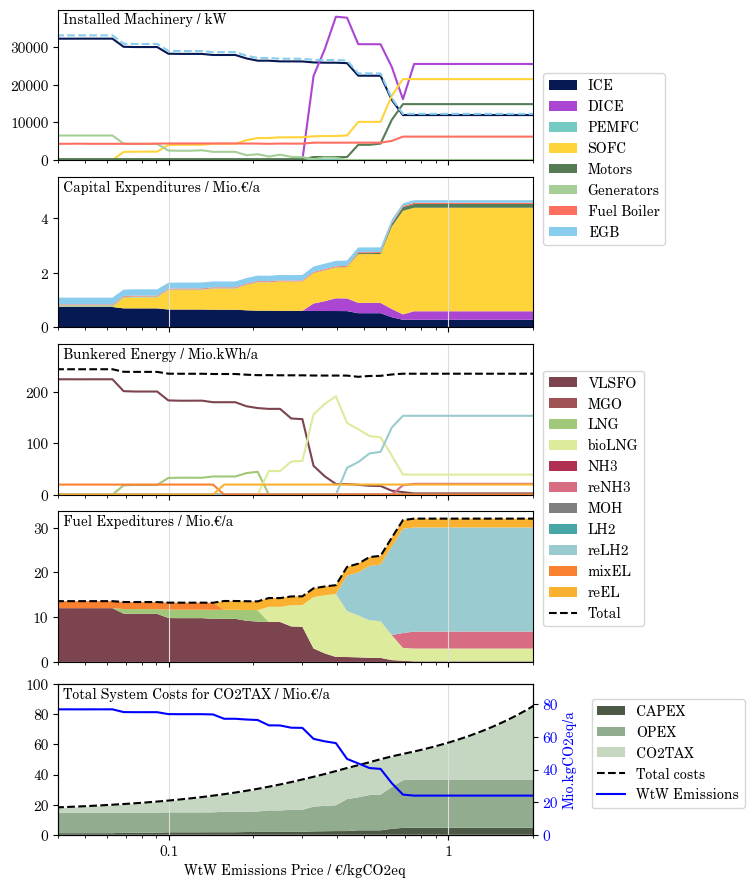

In [39]:
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Century Schoolbook"],
})

s = 12
fig, (ax1, axcapex, ax2, axfuelex, ax3) = plt.subplots(5,1,sharex=True,figsize=(s*(210-80)/210,s*(297-80)/297),constrained_layout=True)

# x = FuelEU[:,0]
x = np.array(carbon)[:,1]
ax1.set_xscale('log')
ax2.set_xscale('log')
ax3.set_xscale('log')
ax3.set_xlabel('WtW Emissions Price / €/kgCO2eq')
def log_format(x, pos):
    if x in [1, 10, 100, 1000]:
        return f'{x:.0f}'
    if x in [0.1]:
        return f'{x:.1f}'
    if x in [0.01]:
        return f'{x:.2f}'
    return f'{x:.3f}'
ax3.xaxis.set_major_formatter(ticker.FuncFormatter(log_format))


# ax1
labels = ['ICE',     'DICE',    'PEMFC',   'SOFC',    'Motors', 'Generators','Fuel Boiler','EGB']
colors = ['#071952', '#AB46D2', '#75CAC3', '#FFD43B', '#557C55', '#A6CF98', '#FF6F61', '#88CCEE']
colorit = iter(colors)
# lists = [list_PEMFC_1, list_PEMFC_2, list_PEMFC_3, list_SOFC_1, list_SOFC_2, list_SOFC_3, list_ICE_1, list_ICE_2, list_ICE_3, list_ICE_4, list_DICE, list_MOT, list_GEN, list_BOIL, list_EGB] # list_HFO, 
# names = ['PEMFC', 'SOFC', 'ICE', 'DICE', 'MOT', 'GEN', 'BOIL', 'EGB', 'Total'] # 'HFO', 
# ax1.plot(x, list_ICE_1, linestyle=(0,(5,2,1,2)), color='black', label='ICE 1')
# ax1.plot(x, list_ICE_2, linestyle=(0,(5,2,1,2,1,2)), color='black', label='ICE 2')
# ax1.plot(x, list_ICE_3, linestyle=(0,(5,2,1,2,1,2,1,2)), color='black', label='ICE 3')
# ax1.plot(x, list_ICE_4, linestyle=(0,(5,2,1,2,1,2,1,2,1,2)), color='black', label='ICE 4')
ax1.plot(x, np.array(list_ICE_1)+np.array(list_ICE_2)+np.array(list_ICE_3)+np.array(list_ICE_4), color=next(colorit))#, linestyle=(0,(5,2,1,2)), color='black', label='ICE')
ax1.plot(x, list_DICE, label='Dual Fuel', color=next(colorit))
ax1.plot(x, np.array(list_PEMFC_1)+np.array(list_PEMFC_2)+np.array(list_PEMFC_3), color=next(colorit))#, linestyle=(0,(6,1)), color='blue', label='PEMFC')
ax1.plot(x, np.array(list_SOFC_1)+np.array(list_SOFC_2)+np.array(list_SOFC_3), color=next(colorit))#, linestyle=(0,(3,1)), color='red', label='SOFC')
# ax1.plot(x, list_DCAC, label='list_DCAC')
ax1.plot(x, list_MOT, color=next(colorit))#, label='Propulsion Motor')
# ax1.plot(x, list_PTI, label='PTI Motor')
ax1.plot(x, list_GEN, color=next(colorit))#, label='PTO Generator')
ax1.plot(x, list_BOIL, color=next(colorit))#, label='Fuel Boiler')
ax1.plot(x, list_EGB, '--', color=next(colorit))#, label='Exhaust Gas Boiler')
# ax1.plot(x, list_RO, label='list_RO')
# ax1.set_ylabel('Machinery / kW')
# ax1.plot(x, sum([np.array(list_machinery) for list_machinery in lists]), '--', color='black', label='Total')
ax1.set_ylim(0,)
# ax1.legend(bbox_to_anchor=(1.01, 1.05), loc="upper left") # https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot
ax1.xaxis.grid(True, color='#ddd')
ax1.set_title('Installed Machinery / kW', loc='left', pad=-20, x=0.01, y=1.09, fontsize=10)

# axcapex
list_ICE = (np.array(list_ICE_1)+np.array(list_ICE_2)+np.array(list_ICE_3)+np.array(list_ICE_4))
list_DICE = np.array(list_DICE)
list_PEMFC = (np.array(list_PEMFC_1)+np.array(list_PEMFC_2)+np.array(list_PEMFC_3))
list_SOFC = (np.array(list_SOFC_1)+np.array(list_SOFC_2)+np.array(list_SOFC_3))
list_MOT = np.array(list_MOT)
# list_GEN = np.array(list_GEN) # +np.array(list_PTI)
list_BOIL = np.array(list_BOIL)
list_EGB = np.array(list_EGB)
axcapex.stackplot(x, list_ICE*capex_ICE/1e6, list_DICE*capex_DICE/1e6, list_PEMFC*capex_PEMFC/1e6, list_SOFC*capex_SOFC/1e6, np.array(list_MOT)*capex_MOT/1e6, np.array(list_GEN)*capex_MOT/1e6, np.array(list_BOIL)*capex_BOIL/1e6, np.array(list_EGB)*capex_EGB/1e6, labels=labels, colors=colors)
# axcapex.set_ylabel('CAPEX / Mio.€/a')
# axcapex.legend(bbox_to_anchor=(1.01, 1.05), loc="upper left")
axcapex.xaxis.grid(True, color='#ddd')
axcapex.set_title('Capital Expenditures / Mio.€/a', loc='left', pad=-20, x=0.01, y=1.09, fontsize=10)

handles_axcapex, labels_axcapex = axcapex.get_legend_handles_labels()
x0, y0, width, height = axcapex.get_position().bounds
fig.legend(handles_axcapex, labels_axcapex, loc='upper left', bbox_to_anchor=(x0+width*0.76, y0+height+0.21), ncol=1) ############################


# ax2
colors = ['#7C444F','#9F5255','#a0c878','#ddeb9d','#b03052','#d76c82','gray','#48a6a7','#9acbd0','#FA812F','#FAB12F'] # 'brown',
colorit = iter(colors)
lists = [list_VLSFO, list_MGO, list_LNG, list_bioLNG, list_NH3, list_reNH3, list_MOH, list_LH2, list_reLH2, list_mixEL, list_reEL] # list_HFO, 
names = ['VLSFO', 'MGO', 'LNG', 'bioLNG', 'NH3', 'reNH3', 'MOH', 'LH2', 'reLH2', 'mixEL', 'reEL'] # 'HFO', 
for i, list_fuel in enumerate(lists):
    ax2.plot(x, np.array(list_fuel)/1e6, color=next(colorit), label=names[i])
# ax2.set_ylabel('Bunkered Energy / Mio.kWh/a')
ax2.plot(x, sum([np.array(list_fuel)/1e6 for list_fuel in lists]), '--', color='black', label='Total')
# ax2.legend(bbox_to_anchor=(1.01, 1.05), loc="upper left", ncol=2)
ax2.xaxis.grid(True, color='#ddd')
ax2.set_title('Bunkered Energy / Mio.kWh/a', loc='left', pad=-20, x=0.01, y=1.09, fontsize=10)
ax2.set_ylim(0,max(sum([np.array(list_fuel)/1e6 for list_fuel in lists]))*1.2)


# axfuelex
# list_FUEL kWh * cost_VLSFO €/kg * 3.6 MJ/kWh / LHV_HFO kg/MJ = €/kWh
# fex_HFO = np.array(list_HFO) * cost_HFO *3.6/LHV_HFO
fex_VLSFO = np.array(list_VLSFO) * cost_VLSFO *3.6/LHV_HFO
fex_MGO = np.array(list_MGO) * cost_MGO *3.6/LHV_MGO
fex_LNG = np.array(list_LNG) * cost_LNG *3.6/LHV_LNG
fex_bioLNG = np.array(list_bioLNG) * cost_bioLNG *3.6/LHV_LNG
fex_LH2 = np.array(list_LH2) * cost_LH2 *3.6/LHV_LH2
fex_reLH2 = np.array(list_reLH2) * cost_reLH2 *3.6/LHV_LH2
fex_NH3 = np.array(list_NH3) * cost_NH3 *3.6/LHV_NH3
fex_reNH3 = np.array(list_reNH3) * cost_reNH3 *3.6/LHV_NH3
fex_MOH = np.array(list_MOH) * cost_MOH *3.6/LHV_MOH
fex_mixEL = np.array(list_mixEL) * cost_mixEL
fex_reEL = np.array(list_reEL) * cost_reEL
axfuelex.stackplot(x, fex_VLSFO/1e6, fex_MGO/1e6, fex_LNG/1e6, fex_bioLNG/1e6, fex_NH3/1e6, fex_reNH3/1e6, fex_MOH/1e6, fex_LH2/1e6, fex_reLH2/1e6, fex_mixEL/1e6, fex_reEL/1e6, labels=names, colors=colors) # fex_HFO/1e6, 
axfuelex.plot(x, (fex_VLSFO+fex_MGO+fex_LNG+fex_bioLNG+fex_NH3+fex_reNH3+fex_MOH+fex_LH2+fex_reLH2+fex_reEL+fex_mixEL)/1e6, '--', color='black', label='Total')
# axfuelex.legend(bbox_to_anchor=(1.01, 1.05), loc="upper left", ncol=2)
axfuelex.xaxis.grid(True, color='#ddd')
axfuelex.set_title('Fuel Expeditures / Mio.€/a', loc='left', pad=-20, x=0.01, y=1.09, fontsize=10)

handles_axfuelex, labels_axfuelex = axfuelex.get_legend_handles_labels()
x0, y0, width, height = ax2.get_position().bounds
fig.legend(handles_axfuelex, labels_axfuelex, loc='upper left', bbox_to_anchor=(x0+width*0.76, y0+height+0.03), ncol=1)


# ax3
colors = ['#4B5945','#91AC8F','#c5d7c1']
labels = ['CAPEX','OPEX','CO2TAX']
capex = list_ICE*capex_ICE+list_DICE*capex_DICE+list_PEMFC*capex_PEMFC+list_SOFC*capex_SOFC+list_MOT*capex_MOT+list_BOIL*capex_BOIL+list_EGB*capex_EGB
opex = fex_VLSFO+fex_MGO+fex_LNG+fex_bioLNG+fex_LH2+fex_reLH2+fex_NH3+fex_reNH3+fex_MOH+fex_mixEL+fex_reEL # fex_HFO+
co2tax = np.array(list_WtW)*x
costplot = ax3.stackplot(x, capex/1e6, opex/1e6, co2tax/1e6, colors=colors, labels=labels)

color = 'black'
tco = ax3.plot(x, np.array(list_obj)/1e6, '--', color=color, label='Total costs')
ax3.set_ylim(0,100)
ax3.tick_params(axis='y', labelcolor=color)
ax3.xaxis.grid(True, color='#ddd')
# ax3.set_yscale('log')
ax3t = ax3.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'blue'
ax3t.set_ylabel('Mio.kgCO2eq/a', color=color)  # we already handled the x-label with ax1
ax3t.tick_params(axis='y', labelcolor=color)
wtw = ax3t.plot(x, np.array(list_WtW)/1e6, '-', color=color, label='WtW Emissions')#, label='FuelEU Maritime GHG trajectory')
ax3t.set_ylim(0,max(np.array(list_WtW)/1e6)*1.2)

ax3.legend(handles=costplot+tco+wtw, bbox_to_anchor=(1.01+0.1, 0.95), loc="upper left")
ax3.set_title('Total System Costs for CO2TAX / Mio.€/a', loc='left', pad=-20, x=0.01, y=1.09, fontsize=10)

# for i in range(len(FuelEU)):
#     plt.annotate(f"{100-FuelEU[:,1][i]} %", (FuelEU[:,0][i], FuelEU[:,2][i]-6), ha='center', color=color)


ax1.set_xlim(0.04,2)

plt.savefig("techtrajectory.svg", bbox_inches='tight');